In [1]:
! pip install -q kaggle
from google.colab import files
files.upload()
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

!kaggle datasets download -d nipunarora8/age-gender-and-ethnicity-face-data-csv

Saving kaggle.json to kaggle.json
 96% 61.0M/63.2M [00:01<00:00, 52.3MB/s]
100% 63.2M/63.2M [00:01<00:00, 62.2MB/s]


In [2]:
!unzip age-gender-and-ethnicity-face-data-csv.zip  && rm age-gender-and-ethnicity-face-data-csv.zip

Archive:  age-gender-and-ethnicity-face-data-csv.zip
  inflating: age_gender.csv          


In [3]:
import numpy as np 
import pandas as pd
import tensorflow as tf
import tensorflow.keras.layers as L
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.express as px
from sklearn.model_selection import train_test_split

from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Input, Conv2D, MaxPool2D, GlobalMaxPool2D
from tensorflow.keras import optimizers
from keras.optimizers import Adam
from keras.layers import MaxPooling2D, BatchNormalization, LeakyReLU, Activation
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau

In [4]:
data = pd.read_csv('age_gender.csv')

## Converting pixels into numpy array
data['pixels']=data['pixels'].apply(lambda x:  np.array(x.split(), dtype="float32"))

data.head()

,age,ethnicity,gender,img_name,pixels
0,1,2,0,20161219203650636.jpg.chip.jpg,"[129.0, 128.0, 128.0, 126.0, 127.0, 130.0, 133..."
1,1,2,0,20161219222752047.jpg.chip.jpg,"[164.0, 74.0, 111.0, 168.0, 169.0, 171.0, 175...."
2,1,2,0,20161219222832191.jpg.chip.jpg,"[67.0, 70.0, 71.0, 70.0, 69.0, 67.0, 70.0, 79...."
3,1,2,0,20161220144911423.jpg.chip.jpg,"[193.0, 197.0, 198.0, 200.0, 199.0, 200.0, 202..."
4,1,2,0,20161220144914327.jpg.chip.jpg,"[202.0, 205.0, 209.0, 210.0, 209.0, 209.0, 210..."


In [5]:
len(data[data.age>60])

2395

Total rows: 23705
Total columns: 5


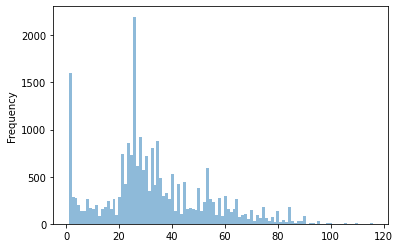

In [6]:
print('Total rows: {}'.format(len(data)))
print('Total columns: {}'.format(len(data.columns)))
data['age'].plot.hist(bins=len(data['age'].unique()), alpha=0.5)

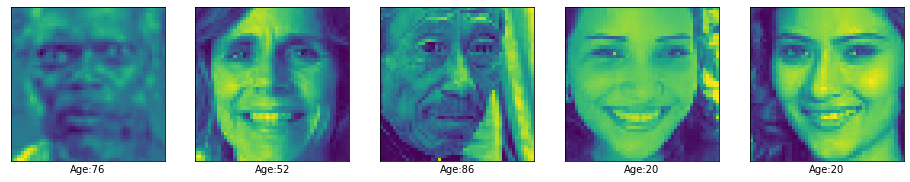

In [7]:
import matplotlib.pyplot as plt
import random
X = np.array(data['pixels'].tolist())
## Converting pixels from 1D to 3D
X = X.reshape(X.shape[0],48,48,1)

plt.figure(figsize=(16,16))
for i in range(5):
    index = random.randint(0,len(data))
    plt.subplot(1,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(X[index].reshape(48,48))
    plt.xlabel("Age:"+str(data['age'][index]))
plt.show()


In [8]:
y = data['age']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=None)

In [9]:
def build_net():
    model = Sequential(name='DCNN')

    model.add(Conv2D(filters=64,kernel_size=(5,5),input_shape=(48, 48, 1),activation='elu',padding='same',kernel_initializer='he_normal',name='conv2d_1'))
    model.add(BatchNormalization(name='batchnorm_1'))
    model.add(Conv2D(filters=64,kernel_size=(5,5),activation='elu',padding='same',kernel_initializer='he_normal',name='conv2d_2'))
    model.add(BatchNormalization(name='batchnorm_2'))
    
    model.add(MaxPooling2D(pool_size=(2,2), name='maxpool2d_1'))
    model.add(Dropout(0.4, name='dropout_1'))

    model.add(Conv2D(filters=128,kernel_size=(3,3),activation='elu',padding='same',kernel_initializer='he_normal',name='conv2d_3'))
    model.add(BatchNormalization(name='batchnorm_3'))
    model.add(Conv2D(filters=128,kernel_size=(3,3),activation='elu',padding='same',kernel_initializer='he_normal',name='conv2d_4'))
    model.add(BatchNormalization(name='batchnorm_4'))
    
    model.add(MaxPooling2D(pool_size=(2,2), name='maxpool2d_2'))
    model.add(Dropout(0.4, name='dropout_2'))

    model.add(Conv2D(filters=256,kernel_size=(3,3),activation='elu',padding='same',kernel_initializer='he_normal',name='conv2d_5'))
    model.add(BatchNormalization(name='batchnorm_5'))
    
    model.add(Conv2D(filters=256,kernel_size=(3,3),activation='elu',padding='same',kernel_initializer='he_normal',name='conv2d_6'))
    model.add(BatchNormalization(name='batchnorm_6'))
    
    model.add(MaxPooling2D(pool_size=(2,2), name='maxpool2d_3'))
    model.add(Dropout(0.5, name='dropout_3'))

    model.add(Flatten(name='flatten'))    
    model.add(Dense(128,activation='elu',kernel_initializer='he_normal',name='dense_1'))
    model.add(BatchNormalization(name='batchnorm_7'))
    model.add(Dropout(0.6, name='dropout_4'))
    
    model.add(Dense(1,activation='relu',name='out_layer'))

    model.compile(loss='mean_squared_error',optimizer='adam',metrics=['mae'])
    model.summary()
    
    return model

In [10]:
model = build_net()

Model: "DCNN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 48, 48, 64)        1664      
_________________________________________________________________
batchnorm_1 (BatchNormalizat (None, 48, 48, 64)        256       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 48, 48, 64)        102464    
_________________________________________________________________
batchnorm_2 (BatchNormalizat (None, 48, 48, 64)        256       
_________________________________________________________________
maxpool2d_1 (MaxPooling2D)   (None, 24, 24, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 24, 24, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 24, 24, 128)       73856  

In [11]:
history = model.fit(
    X_train,
    y_train,
    epochs=20,
    validation_data = (X_test, y_test),
    batch_size=64)

Epoch 1/20
297/297 [==============================] - 47s 44ms/step - loss: 939.2926 - mae: 24.6751 - val_loss: 2033.3466 - val_mae: 41.5528
Epoch 2/20
297/297 [==============================] - 12s 41ms/step - loss: 249.4596 - mae: 11.9925 - val_loss: 839.5571 - val_mae: 26.5305
Epoch 3/20
297/297 [==============================] - 12s 41ms/step - loss: 163.0572 - mae: 9.5652 - val_loss: 692.6878 - val_mae: 23.2368
Epoch 4/20
297/297 [==============================] - 12s 41ms/step - loss: 131.7984 - mae: 8.6001 - val_loss: 105.8203 - val_mae: 7.8177
Epoch 5/20
297/297 [==============================] - 12s 42ms/step - loss: 121.8349 - mae: 8.3381 - val_loss: 106.6062 - val_mae: 7.7566
Epoch 6/20
297/297 [==============================] - 12s 42ms/step - loss: 114.5303 - mae: 7.9813 - val_loss: 123.8065 - val_mae: 8.5623
Epoch 7/20
297/297 [==============================] - 12s 41ms/step - loss: 103.6723 - mae: 7.6011 - val_loss: 102.9389 - val_mae: 7.6101
Epoch 8/20
297/297 [========

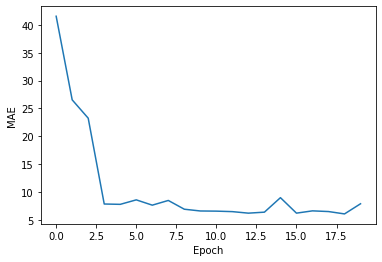

In [13]:
plt.plot(history.history['val_mae'])
plt.xlabel("Epoch")
plt.ylabel("MAE")
model.save_weights('age_model.h5')